### Secondary cloud filtering for training data

This may not be necessary when CloudScore+ masking has been applied with high clear_threshold. Regardless, it's helpful to review the training data for clouds. 

In [2]:
from datetime import date
import glob
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import rasterio

parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from scripts import viz_tools

WORK_DIR = '../data/training_patches'

%load_ext autoreload
%autoreload 2

In [3]:
def read_tif(path):
    with rasterio.open(path) as f:
        img = f.read()
    img = np.moveaxis(img, 0, -1)
    return img.astype('float32')

positive_paths = glob.glob(f"{WORK_DIR}/train/0/*.tif")
positive_patches = np.array([read_tif(p) for p in positive_paths])
negative_paths = glob.glob(f"{WORK_DIR}/train/1/*.tif")
negative_patches = np.array([read_tif(p) for p in negative_paths])

print(len(positive_patches), "positive samples loaded")
print(len(negative_patches), "negative samples loaded")

250 positive samples loaded
1421 negative samples loaded


In [8]:
def filter_white(data, mask_limit=0.1, bright_level=2000, return_rejects=False):
    masked_fraction = np.array([np.sum(np.mean(patch[:,:,1:2], axis=-1) > bright_level) / np.size(np.mean(patch[:,:,1:2], axis=-1)) for patch in data])
    filtered_data = data[masked_fraction <= mask_limit]
    print(f"{len(filtered_data) / len(data) :.1%} of data passes filter")
    if return_rejects:
        rejected_indices = np.where(masked_fraction > mask_limit)[0]
        rejected_data = data[rejected_indices]
        return filtered_data, rejected_data, rejected_indices
    else:
        return filtered_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4276666641235352].


93.2% of data passes filter


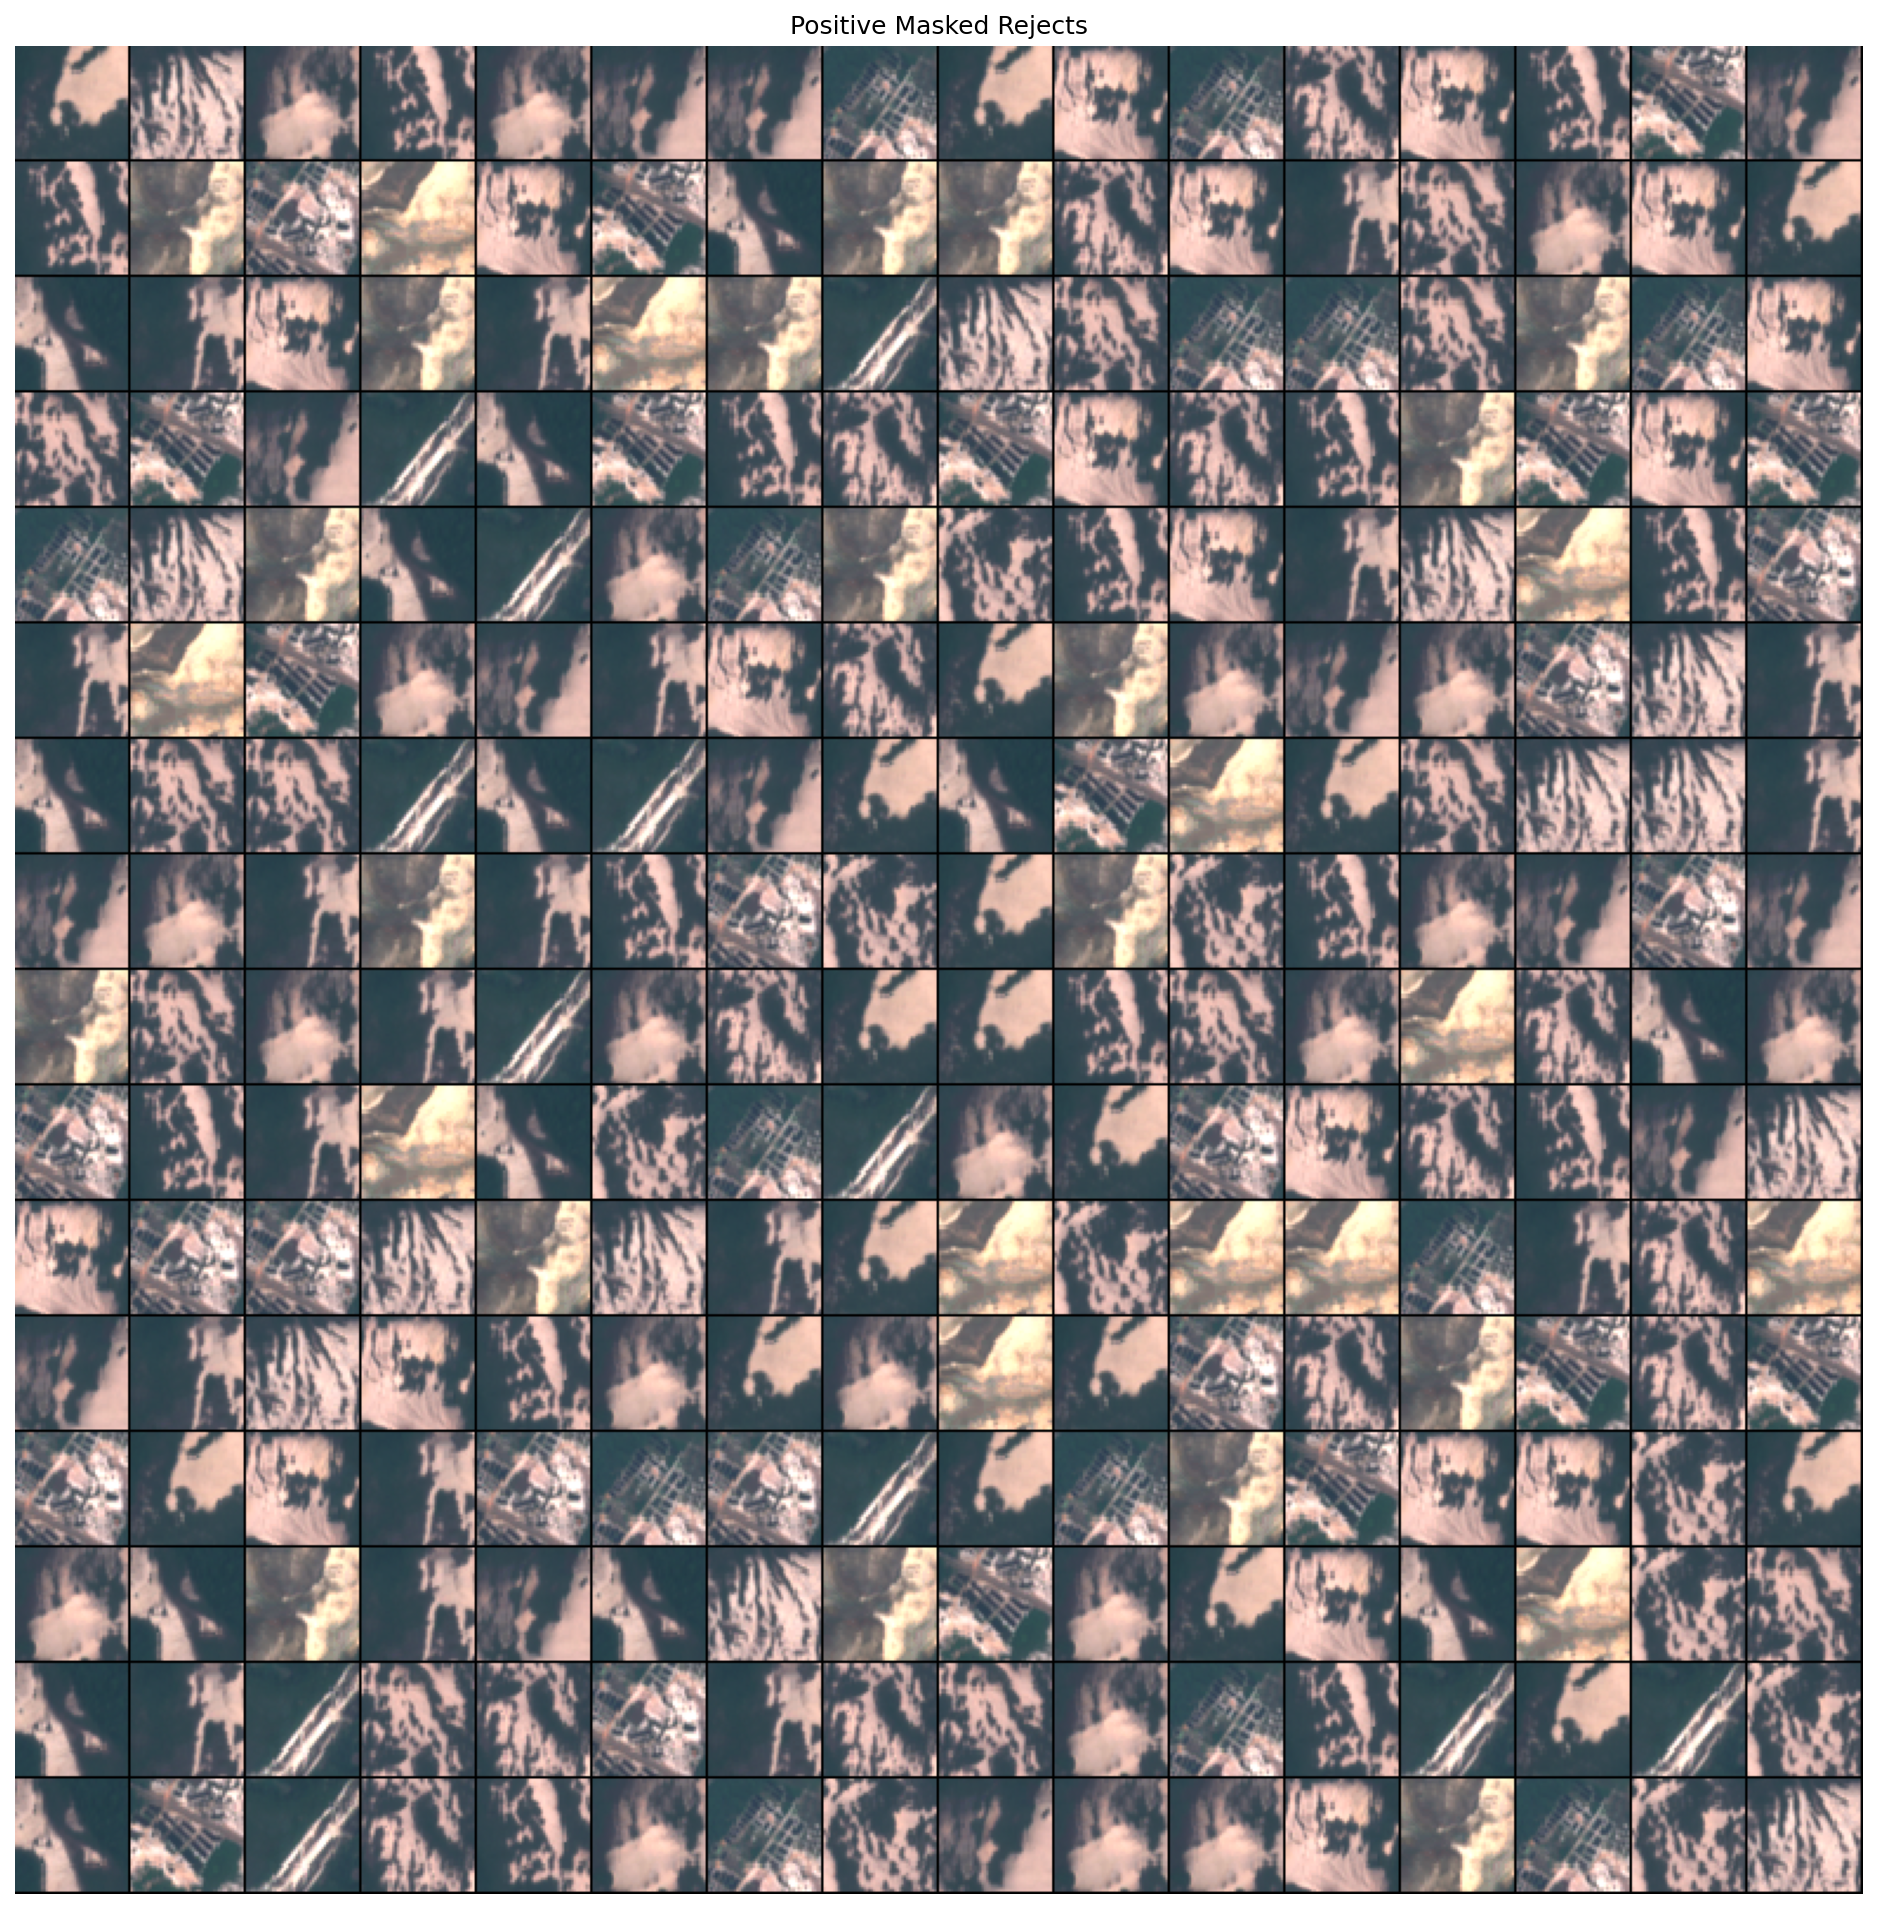

In [9]:
# Filter positive pixels that are masked beyond a threshold. Don't want to give positive examples of cloud-masked patches
filtered_positives, positive_rejects, rejected_indices = filter_white(positive_patches, mask_limit = 0.1, return_rejects=True)
if len(positive_rejects) > 0:
    num_samples = 16**2
    indices = np.random.randint(0, len(positive_rejects), num_samples)
    viz_tools.plot_numpy_grid(positive_rejects[indices,:,:,3:0:-1] / 3000)
    plt.title("Positive Masked Rejects")
    plt.show()


In [18]:
for src in np.array(positive_paths)[rejected_indices]:
    dest_dir = os.path.join(os.path.dirname(src), 'cloud_rejects')
    os.makedirs(dest_dir, exist_ok=True)
    dest = os.path.join(dest_dir, os.path.basename(src))
    shutil.move(src, dest)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7196667194366455].


99.9% of data passes filter


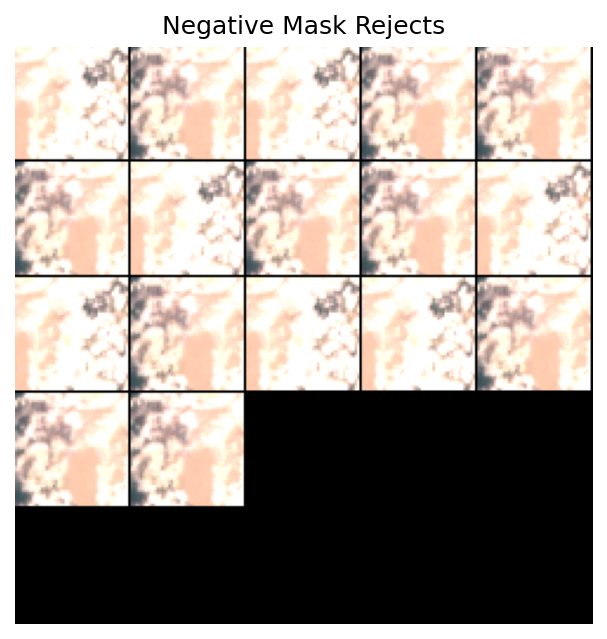

In [10]:
filtered_negatives, negative_rejects, rejected_indices = filter_white(negative_patches, mask_limit = .8, return_rejects=True)
if len(negative_rejects) > 0:
    num_samples = 16**2
    if len(negative_rejects) < num_samples:
        num_samples = len(positive_rejects)
    indices = np.random.randint(0, len(negative_rejects), num_samples)
    viz_tools.plot_numpy_grid(negative_rejects[indices,:,:,3:0:-1] / 3000)
    plt.title("Negative Mask Rejects")
    plt.show()


In [14]:
cloudy = np.array(negative_paths)[rejected_indices]
random.shuffle(cloudy)
print(len(cloudy))

5157


In [15]:
n_to_remove = 3000
for src in cloudy[:n_to_remove]:
    dest_dir = os.path.join(os.path.dirname(src), 'cloud_rejects')
    os.makedirs(dest_dir, exist_ok=True)
    dest = os.path.join(dest_dir, os.path.basename(src))
    shutil.move(src, dest)